# Voice Control with PSoC 6

###### Copyright 2020 The TensorFlow Authors.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set this to True to install requirements
INSTALL_REQ = True 

# Set this to True to download dataset
DOWNLOAD_DATASET = False

# Set this to True to unzip dataset
UNZIP_DATASET = False

# Dataset download link

DATASET_LINK = "https://drive.google.com/u/0/uc?id=1P-emUY9VsU6fXb3VJnSEmPQVqnPI2lgP"

# Path to your mounted google drive
GDRIVE_LOC = "/content/drive/MyDrive"

# Working directory in google drive
WORKING_LOC = "/iHack_UR"

# Full working path
FULL_WORKING_LOC = GDRIVE_LOC + WORKING_LOC

# Path to extract dataset
DATASET_PATH = FULL_WORKING_LOC + "/dataset_ihack"

In [ ]:
if INSTALL_REQ:
  !pip install git+https://github.com/ARM-software/CMSIS_5.git@5.9.0#egg=CMSISDSP\&subdirectory=CMSIS/DSP/
  !sudo apt-get install libportaudio2
  !pip install audiomentations
  !pip install sounddevice
  !pip install python_speech_features


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ARM-software/CMSIS_5.git (to revision 5.9.0) to /tmp/pip-install-o37v22sh/cmsisdsp_062cd8a89154432b92073f20a954b441
  Running command git clone --filter=blob:none --quiet https://github.com/ARM-software/CMSIS_5.git /tmp/pip-install-o37v22sh/cmsisdsp_062cd8a89154432b92073f20a954b441
  Running command git checkout -q 61e36449f53c25ef7825c40f7dd93685736f457f
  Resolved https://github.com/ARM-software/CMSIS_5.git to commit 61e36449f53c25ef7825c40f7dd93685736f457f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 4.5 MB/s eta 0:00:00
  Created wheel for CMSISDSP: filename=cmsisdsp-1.4.0-cp310-cp310-linux_x86_64.whl size=3089763 sha256=fd33610f64d6a36eff332adba66e1815b197b66433d18384198288f0ce8ef81b
  Stored in directory: /

In [ ]:
  !pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
if DOWNLOAD_DATASET:
  !rm -rf /content/drive/MyDrive/iHack_UR

  import os
  import gdown

  os.mkdir(FULL_WORKING_LOC)

  # a file
  url = DATASET_LINK
  output = FULL_WORKING_LOC + "/dataset.zip"
  gdown.download(url, output, quiet=False)

In [ ]:
if UNZIP_DATASET:
  import zipfile
  with zipfile.ZipFile(FULL_WORKING_LOC + "/dataset.zip", 'r') as zip_ref:
    zip_ref.extractall(DATASET_PATH)

In [ ]:
Err_sol = False 
if Err_sol == True :
    !pip install pandas_ta==0.2.45b
    !pip uninstall numpy
    !pip uninstall numba
    !pip install -U numba

### Import Python Packages

In [ ]:
# Import required packages

import os
import pathlib
from IPython import display

import cmsisdsp
from cmsisdsp.datatype import F32
import cmsisdsp.fixedpoint as f
import cmsisdsp.mfcc as cmsismfcc

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow_datasets as tfds
import tensorflow_hub as hub

import numpy as np
from numpy import pi as PI

import scipy.signal as sig
from scipy.io.wavfile import write

import seaborn as sns

import matplotlib.pyplot as plt

import pandas as pd

from audiomentations import SpecCompose, SpecFrequencyMask
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift,AddBackgroundNoise,AddShortNoises
import sounddevice as sd
import python_speech_features
from tensorflow.python.ops import gen_audio_ops as audio_ops

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
tf.__version__

'2.12.0'

## Import the dataset

In [ ]:
data_dir = pathlib.Path(DATASET_PATH)

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
commands = commands[commands != 'LICENSE']
print('Commands:', commands)

Commands: ['off' 'on' 'silence']


In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
[print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[itr])))) for itr in range(len(commands))]
print('Example file tensor:', filenames[0])

Number of total examples: 9590
Number of examples per label: 3745
Number of examples per label: 3845
Number of examples per label: 2000
Example file tensor: tf.Tensor(b'/content/drive/MyDrive/iHack_UR/dataset_ihack/off/f5e5e8b0_nohash_1.wav', shape=(), dtype=string)


Split `filenames` into training, validation and test sets using a 80:10:10 ratio, respectively:

In [ ]:
trainset_80p=num_samples*(80/100)
if (trainset_80p%10 != 0):
    trainset_80p=int(trainset_80p)+1
else:
    trainset_80p=int(trainset_80p)
testset_10p=int(num_samples*(10/100))
print("train set",trainset_80p)
print("test set",testset_10p)
total_set=trainset_80p+testset_10p*2
print("Total set, num samples",total_set,num_samples)

train set 7673
test set 959
Total set, num samples 9591 9590


In [ ]:
train_files = filenames[:trainset_80p]
val_files = filenames[trainset_80p: trainset_80p + testset_10p]
test_files = filenames[-testset_10p:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 7673
Validation set size 959
Test set size 959


## Read the audio files and their labels

In [ ]:
def decode_audio(audio_binary):
    audio, sampling_rate = tf.audio.decode_wav(contents=audio_binary)  # Decode a 16-bit PCM WAV file to a float tensor.
    print(audio.shape)
    return tf.squeeze(audio, axis=-1)

In [ ]:
def get_label(file_path):
    parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
    return parts[-2]

In [ ]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    print("file path",file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    print(label.shape, waveform.shape)
    return waveform, label

## Create a Training TensorFlow Dataset

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(
    map_func=get_waveform_and_label, num_parallel_calls=AUTOTUNE)

file path Tensor("args_0:0", shape=(), dtype=string)
(None, None)
() (None,)


## Plot the Audio waveforms

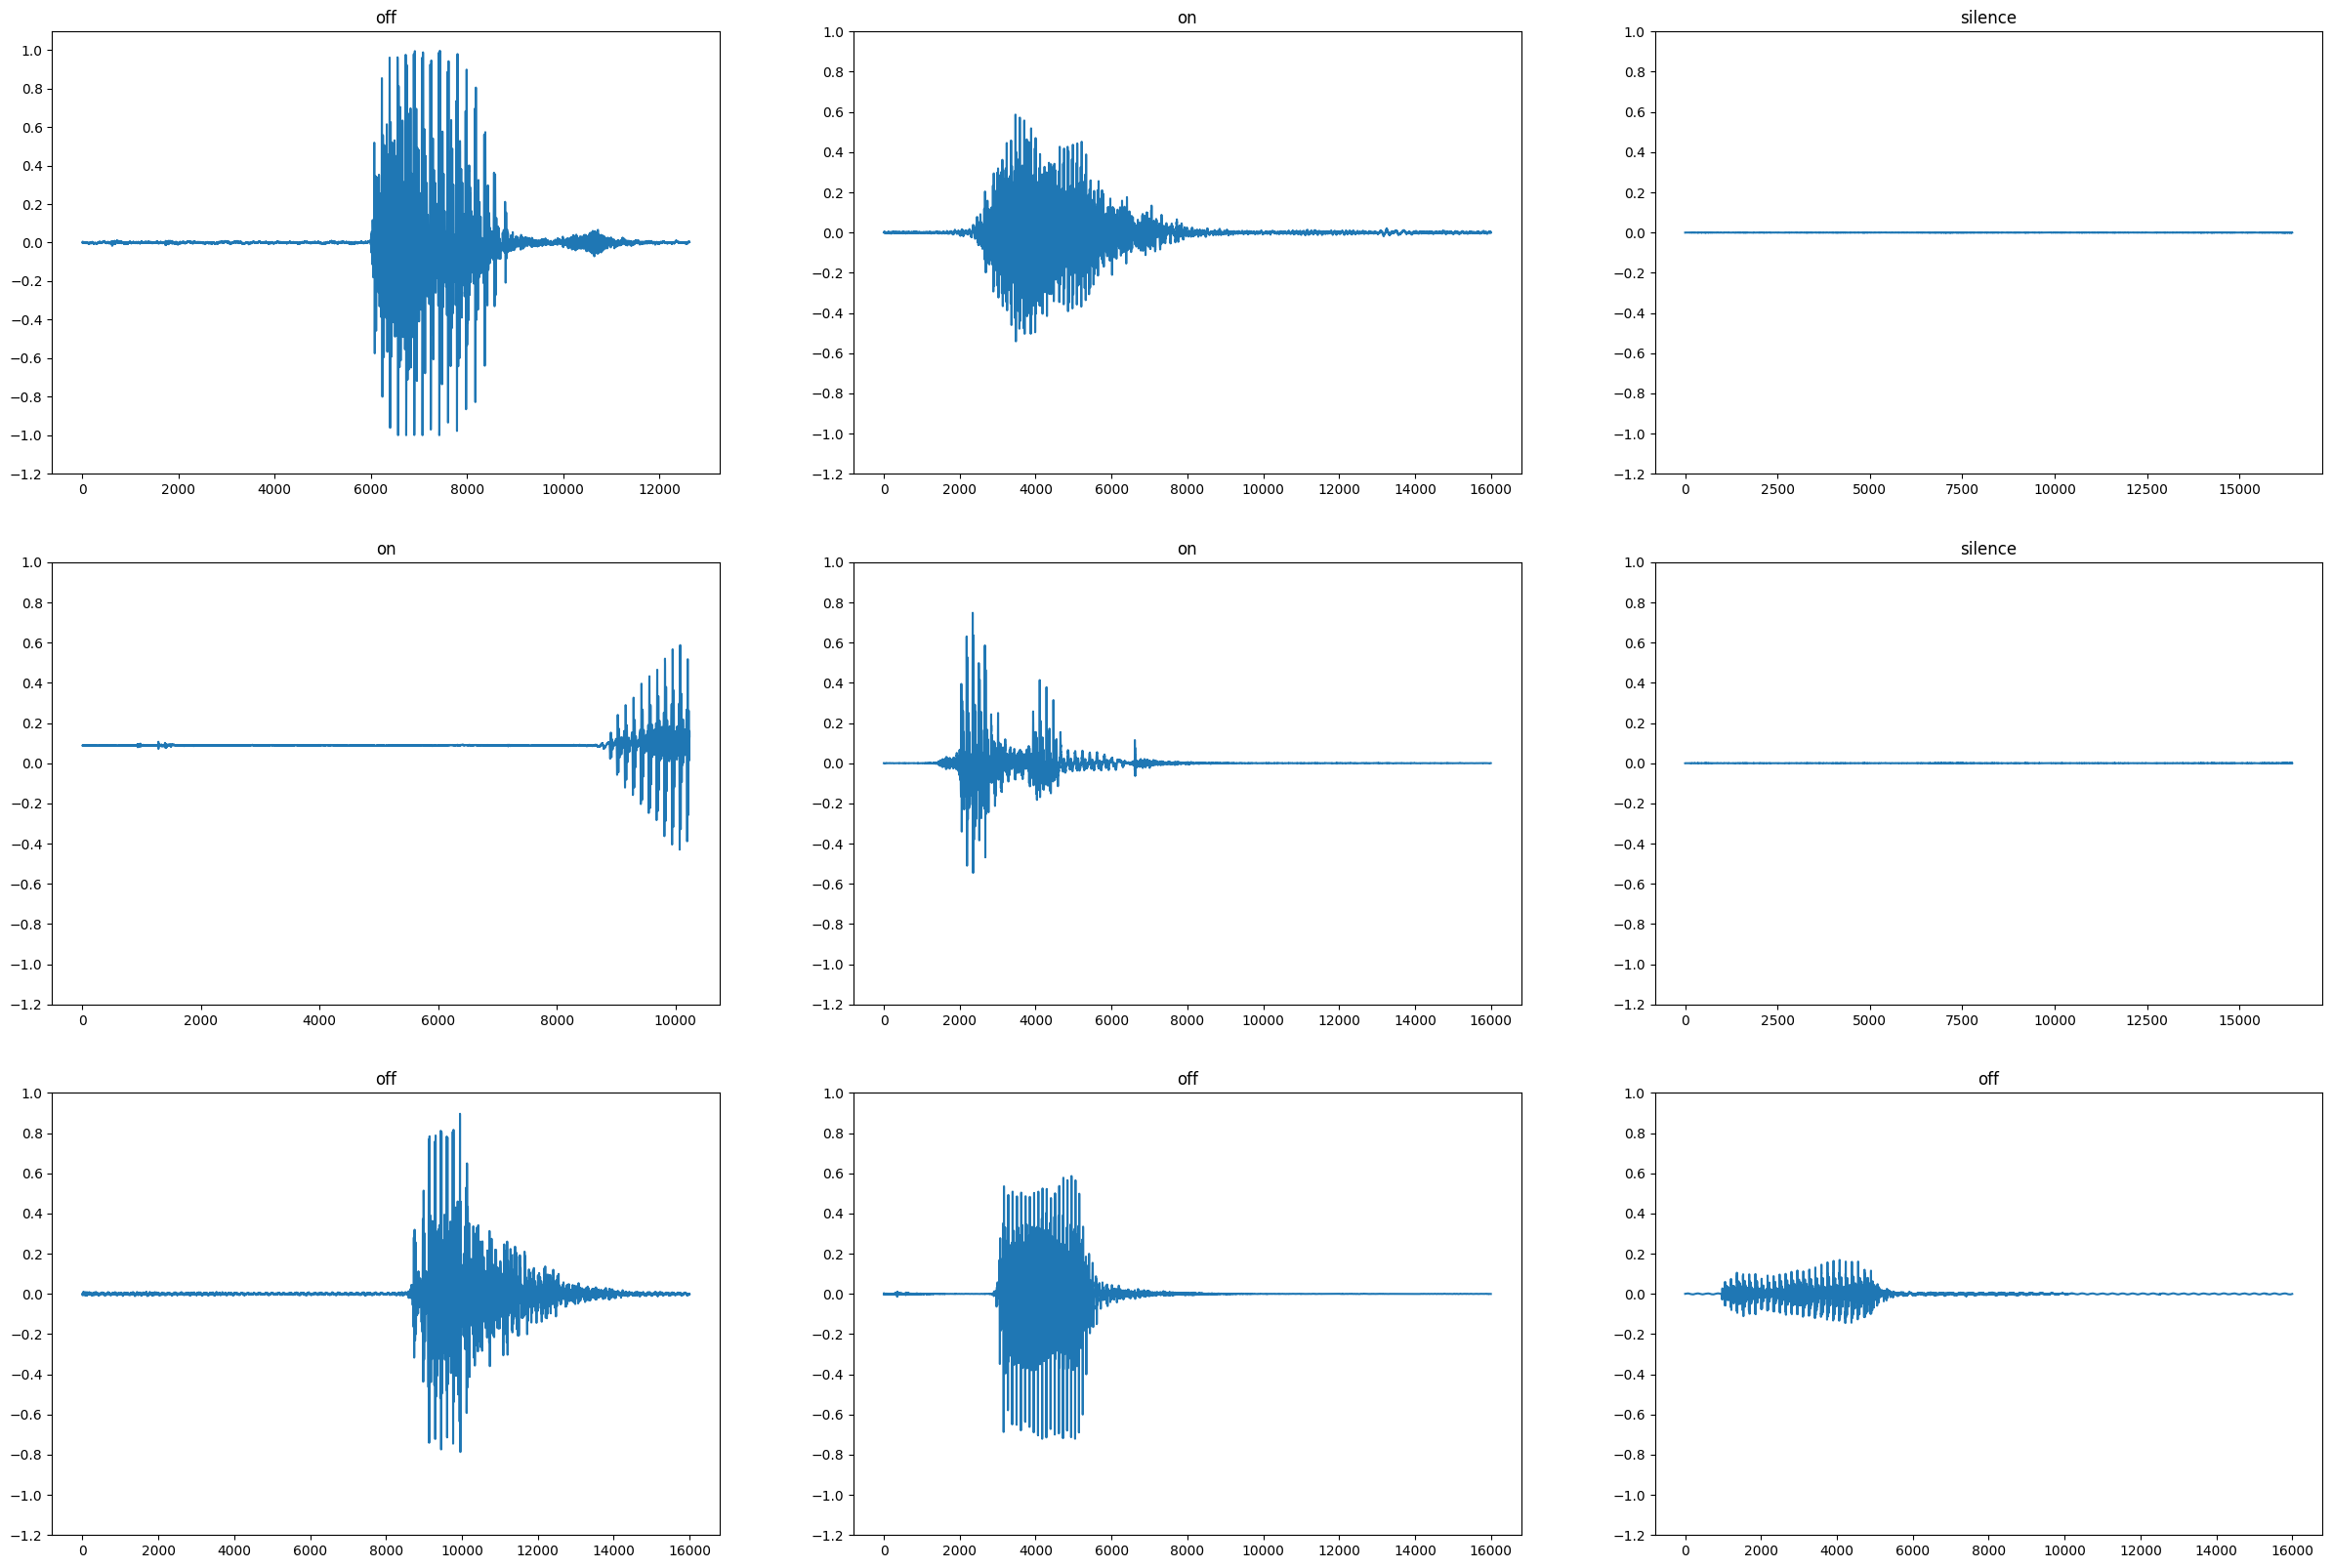

In [ ]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(30, 20))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

## Augment and convert audio data to MFCC

We will augment the data using augmentations package and convert it to MFCC using ARM CMSIS DSP API's.

### Audio Augmentation

In [ ]:
DEMO_DIR = DATASET_PATH

augment_waveform_pipeline = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.05, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])


@tf.function
def tf_augment_wave(waveform):
    pipeline = tf.numpy_function(augment_waveform,[waveform],Tout=tf.float32)
    return pipeline

def augment_waveform(waveform):
    print("augment waveform shape",waveform.shape)
    aug_waveform=augment_waveform_pipeline(samples=waveform,sample_rate=16000)
    print("Augmented shape",aug_waveform.shape)
    return aug_waveform


@tf.function
def tf_augment_wave_to_mfcc(waveform,label):
    label_id = tf.argmax(label == commands)
    return tf.numpy_function(augment_waveform_to_mfcc,[waveform],Tout=tf.float32),label_id

def augment_waveform_to_mfcc(waveform):
    aug_waveform=augment_waveform_pipeline(samples=waveform,sample_rate=16000)
    aug_mfcc=get_cmsis_mfcc_full(aug_waveform)
    return aug_mfcc

## Feature Extraction - MFCC (Mel-Frequency Cepstral Coefficients)

In [ ]:
# MFCC configuration parameters

# Fixed parameters
sampling_rate = 16000
freq_min = 64
freq_high = sampling_rate / 2 # Nyquist rate

# Configurable parameters
FFT_size = 1024
FFT_step_size = 1024 
num_dct_outputs = 60
num_mel_filters = 40


In [ ]:
mfccf32 = cmsisdsp.arm_mfcc_instance_f32()
window = sig.hamming(FFT_size, sym=False)
filtLen,filtPos,packedFilters = cmsismfcc.melFilterMatrix(F32,freq_min, freq_high, num_mel_filters,sampling_rate,FFT_size)
dctMatrixFilters = cmsismfcc.dctMatrix(F32,num_dct_outputs, num_mel_filters)    

status = cmsisdsp.arm_mfcc_init_f32(mfccf32,FFT_size,num_mel_filters,num_dct_outputs,dctMatrixFilters,filtPos,filtLen,packedFilters,window)

@tf.function
def get_cmsis_mfcc_ds(waveform):
    return tf.numpy_function(get_cmsis_mfcc_full,[waveform],Tout=tf.float32)


def get_cmsis_mfcc_full(waveform):  
    input_len = 16384
    waveform = waveform[:input_len] 
    
    zero_padding = tf.zeros(
      [input_len] - tf.shape(waveform),
      dtype=tf.float32)
    
    initial_zero_padding=tf.zeros(FFT_size - FFT_step_size, dtype=tf.float32)
    waveform = tf.cast(waveform, dtype=tf.float32)
    
    # Concatenate the waveform with `zero_padding`, which ensures all audio clips are of the same length.
    equal_length = tf.concat([initial_zero_padding, waveform, zero_padding], 0)
      
    mfcc_full=np.empty(shape=[0,num_dct_outputs],dtype=np.float32)
    
    equal_length=equal_length.numpy()

    start_index=0 
    while start_index<=(len(equal_length)-FFT_size):
        tmp=np.zeros(FFT_size + 2)
        mfcc_res=cmsisdsp.arm_mfcc_f32(mfccf32,equal_length[start_index:start_index+FFT_size],tmp)
        mfcc_full=np.vstack([mfcc_full,mfcc_res])
        start_index=start_index+FFT_step_size
        
    mfcc_full=mfcc_full[...,tf.newaxis]
    mfcc_full=tf.image.per_image_standardization(mfcc_full)
    return mfcc_full

## Playback Audio

In [ ]:
for waveform, label in waveform_ds.take(1):
    print("wave")
    print(len(waveform))
    label = label.numpy().decode('utf-8')
    mfcc_arm=get_cmsis_mfcc_full(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print("MFCC shape",mfcc_arm.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

wave
12632
Label: off
Waveform shape: (12632,)
MFCC shape (16, 60, 1)
Audio playback


In [ ]:
aug_waveform=tf_augment_wave(waveform)
display.display(display.Audio(aug_waveform, rate=16000))

augment waveform shape (12632,)
Augmented shape (12632,)


## Plot the Spectrogram

In [ ]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        print("before squeeze",spectrogram.shape)
        spectrogram = np.squeeze(spectrogram, axis=-1)
        print("after squeeze",spectrogram.shape)

    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec =(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = range(width)
    Y = range(height)
    print("size spectrogram",np.size(spectrogram))
    print("Width",width, "Height",height)
    ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

before squeeze (16, 60, 1)
after squeeze (16, 60)
size spectrogram 960
Width 16 Height 60


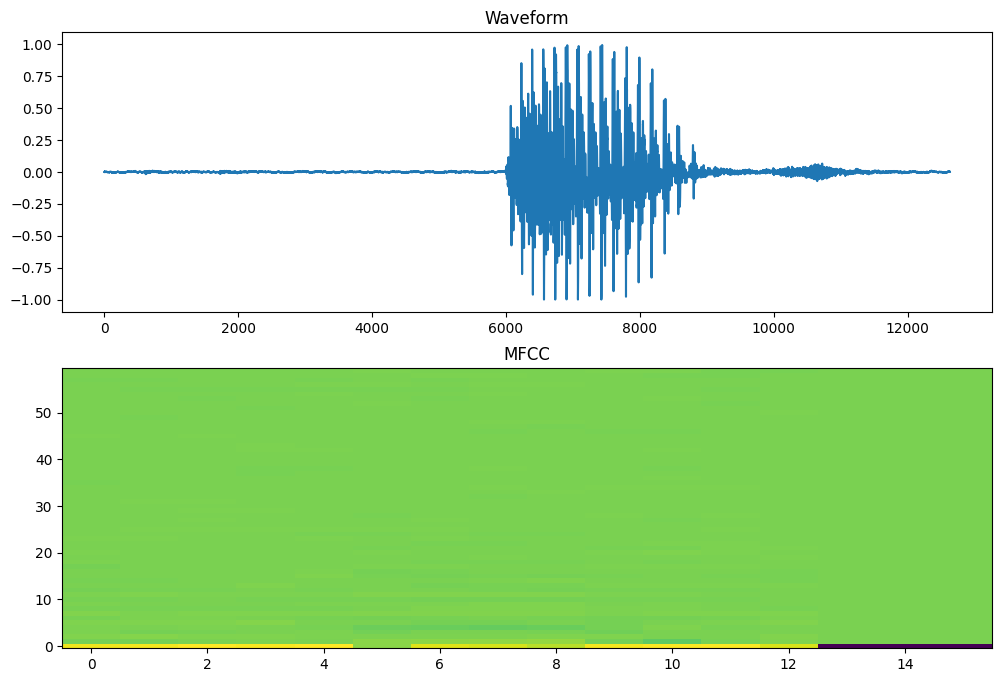

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
plot_spectrogram(mfcc_arm,axes[1])
axes[1].set_title("MFCC")
plt.show()

## Training DS with Spectrograms and Labels

In [ ]:
def get_mfcc_label_id(audio,label):
    mfcc=get_cmsis_mfcc_ds(audio)
    label_id=tf.argmax(label==commands)
    return mfcc, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(map_func=get_mfcc_label_id)

In [ ]:
augmented_spec_ds = waveform_ds.map(map_func=tf_augment_wave_to_mfcc)

## Prepare the training DataSet with Actual+Augmented data and Test,Validation DataSets

In [ ]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds=files_ds.map(map_func=get_waveform_and_label)
    output_ds=output_ds.map(map_func=get_mfcc_label_id)
    return output_ds

In [ ]:
train_ds = spectrogram_ds.concatenate(augmented_spec_ds)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

file path Tensor("args_0:0", shape=(), dtype=string)
(None, None)
() (None,)
file path Tensor("args_0:0", shape=(), dtype=string)
(None, None)
() (None,)


In [ ]:
# Check for number of elements in the training dataset
num_of_samples=train_ds.cardinality().numpy()
print(num_of_samples)

15346


In [ ]:
train_shuffle_ds=train_ds.shuffle(num_of_samples,reshuffle_each_iteration=True)
batch_size = 64
train_ds = train_shuffle_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [ ]:
train_ds = train_ds.cache()
val_ds = val_ds.cache()

## Neural Network Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization, AveragePooling2D

for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape

num_labels = len(commands)

# Define the RBM layers
rbm_layer1 = Dense(units=1024, activation='relu', use_bias=True)
rbm_layer2 = Dense(units=512, activation='relu', use_bias=True)
rbm_layer3 = Dense(units=256, activation='relu', use_bias=True)
rbm_layer4 = Dense(units=128, activation='relu', use_bias=True)

dbn_input = Input(shape=input_shape)
x = rbm_layer1(dbn_input)

x = BatchNormalization()(x)
x = Flatten()(x)

x = rbm_layer2(x)
x = BatchNormalization()(x)
x = Flatten()(x)

x = rbm_layer3(x)
x = BatchNormalization()(x)

x = Dense(units=64, activation='relu', use_bias=True)(x)
x = Dropout(0.25)(x)
x = Dense(num_labels, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='softmax')(x)


dbn = tf.keras.models.Model(inputs=dbn_input, outputs=x)
# Use droput after only flatten not after each layer 
# Use ReLu as activation function 
# Try Adding one more layer and see the change , start with lower units 

In [ ]:
dbn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 60, 1)]       0         
                                                                 
 dense (Dense)               (None, 16, 60, 1024)      2048      
                                                                 
 batch_normalization (BatchN  (None, 16, 60, 1024)     4096      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 983040)            0         
                                                                 
 dense_1 (Dense)             (None, 512)               503316992 
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                             

## Compile and Fit the Model

In [ ]:
from tensorflow.keras.optimizers import Adam
dbn.compile(optimizer=Adam(learning_rate=0.0001),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy'])

In [ ]:
EPOCHS = 15
history = dbn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(monitor='accuracy',mode='max',verbose=1, patience=4),
    batch_size=32,
)

Epoch 1/15
240/240 [==============================] - 742s 486ms/step - loss: 0.5993 - accuracy: 0.7805 - val_loss: 1.6492 - val_accuracy: 0.4046
Epoch 2/15
240/240 [==============================] - 35s 144ms/step - loss: 0.3821 - accuracy: 0.8658 - val_loss: 1.0102 - val_accuracy: 0.6840
Epoch 3/15
240/240 [==============================] - 35s 144ms/step - loss: 0.3167 - accuracy: 0.8946 - val_loss: 0.3277 - val_accuracy: 0.8936
Epoch 4/15
240/240 [==============================] - 35s 145ms/step - loss: 0.2733 - accuracy: 0.9108 - val_loss: 0.7426 - val_accuracy: 0.8843
Epoch 5/15
240/240 [==============================] - 35s 146ms/step - loss: 0.2405 - accuracy: 0.9232 - val_loss: 0.3993 - val_accuracy: 0.8832
Epoch 6/15
240/240 [==============================] - 35s 146ms/step - loss: 0.2182 - accuracy: 0.9339 - val_loss: 0.2674 - val_accuracy: 0.9062
Epoch 7/15
240/240 [==============================] - 35s 148ms/step - loss: 0.1953 - accuracy: 0.9429 - val_loss: 0.3013 - val_a

## Plot the Loss

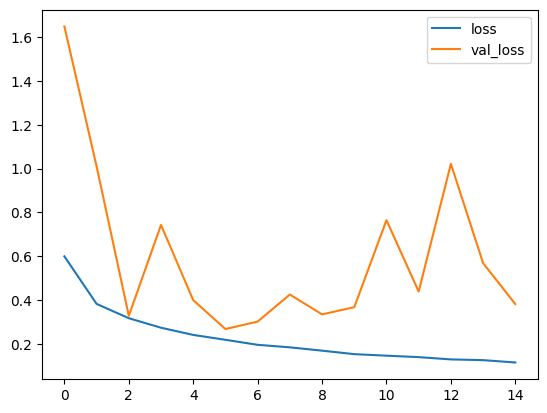

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(dbn.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

30/30 [==============================] - 1s 18ms/step
Test set accuracy: 88%


In [ ]:
dbn.evaluate(test_audio, test_labels)

30/30 [==============================] - 1s 19ms/step - loss: 0.4569 - accuracy: 0.8790


[0.4569292962551117, 0.8790406584739685]

In [ ]:
from sklearn.metrics import classification_report

# Convert y_true to one-hot encoded labels for calculating precision, recall, F1 score
one_hot_y_true = tf.one_hot(y_true, depth=num_labels)

# Get predictions from the model
y_pred = dbn.predict(test_audio)

# Convert predictions to one-hot encoded labels
one_hot_y_pred = tf.one_hot(np.argmax(y_pred, axis=1), depth=num_labels)

# Calculate classification report
report = classification_report(one_hot_y_true, one_hot_y_pred)

# Print classification report
print(report)


30/30 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       364
           1       0.87      0.86      0.87       415
           2       0.96      0.99      0.98       180

   micro avg       0.88      0.88      0.88       959
   macro avg       0.89      0.90      0.90       959
weighted avg       0.88      0.88      0.88       959
 samples avg       0.88      0.88      0.88       959



## Display the confusion matrix


confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20,20))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Save the Model

In [ ]:
# Save the model as h5 file.
dbn.save(FULL_WORKING_LOC + "/psoc6_voice_control_bootcamp_model_cnn.h5")

In [ ]:
# all imports
from IPython.display import display, Javascript
from google.colab import output
from base64 import b64decode

REC = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(REC))
  print('Speak now!')
  s = output.eval_js('record(%d)' % (sec*1000))
  print('Audio captured')
  b = b64decode(s.split(',')[1])
  with open("/content/drive/MyDrive/iHack_UR/voice.ogg",'wb') as f:
    f.write(b)
  return "/content/drive/MyDrive/iHack_UR/voice.ogg"

<IPython.core.display.Javascript object>

Speak now!
Audio captured
(14400, 1)
Predicted off


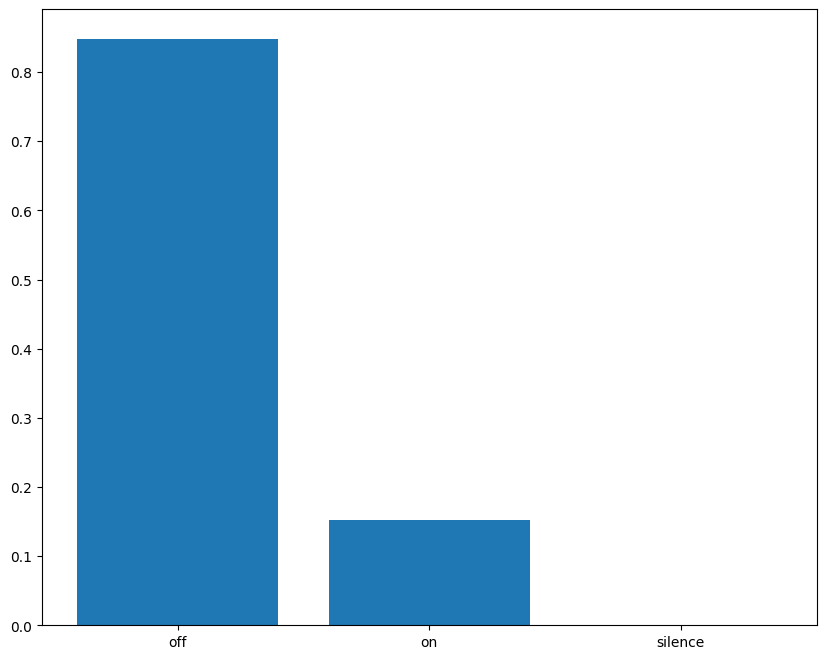

In [ ]:
record(1)
!ffmpeg -loglevel panic -y -i /content/drive/MyDrive/iHack_UR/voice.ogg /content/drive/MyDrive/iHack_UR/voice.wav
!ffmpeg -loglevel panic -y -i /content/drive/MyDrive/iHack_UR/voice.wav -ar 16000 /content/drive/MyDrive/iHack_UR/voice_16k.wav
x = tf.io.read_file("/content/drive/MyDrive/iHack_UR/voice_16k.wav")
waveform = decode_audio(x)
sample_ds=get_cmsis_mfcc_full(waveform)
sample_ds = sample_ds[tf.newaxis,...]
prediction = dbn(sample_ds)
plt.figure(figsize=(10,8))
print("Predicted",commands[tf.math.argmax(prediction[0])])
plt.bar(commands, prediction[0])
plt.show()